# Overfitting and Double Descents

## Abstract

In this blog post, I implement a linear regression model and an overparameterized optimizer to explore deep learning techniques of double descent. I use mean squared error (MSE) to calculate loss and visualizations to how the MSE changed as we increased the number features. In my final test, I graph the plot of MSE and the number of features as it increases to greater than the number of data points. This I graph I saw the double descent. I discoverd that the optimal number of features for me was...

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Random Features Generation

In [25]:
import torch

import matplotlib.pyplot as plt
import numpy as np

def sig(x): 
    return 1/(1+torch.exp(-x))

def square(x): 
    return x**2

class RandomFeatures:
    """
    Random sigmoidal feature map. This feature map must be "fit" before use, like this: 

    phi = RandomFeatures(n_features = 10)
    phi.fit(X_train)
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)

    model.fit(X_train_phi, y_train)
    model.score(X_test_phi, y_test)

    It is important to fit the feature map once on the training set and zero times on the test set. 
    """

    def __init__(self, n_features, activation = sig):
        self.n_features = n_features
        self.u = None
        self.b = None
        self.activation = activation

    def fit(self, X):
        self.u = torch.randn((X.size()[1], self.n_features), dtype = torch.float64)
        self.b = torch.rand((self.n_features), dtype = torch.float64) 

    def transform(self, X: torch.Tensor):
        return self.activation(X @ self.u + self.b)

## Part 0
If p > n then (X^T X)^{-1} is not invertible. The matrix is rank deficient.

## Testing MyLinearRegression Model

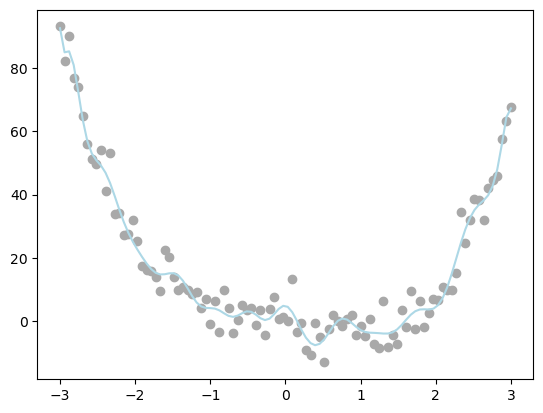

In [64]:
from MyLinearRegression import MyLinearRegression, OverParameterizedLinearRegressionOptimizer
X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype = torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

phi = RandomFeatures(n_features= 100)
phi.fit(X)
X_train_features = phi.transform(X)

LR = MyLinearRegression()
opt = OverParameterizedLinearRegressionOptimizer(LR)
opt.fit(X_train_features, y)
pred = LR.predict(X_train_features)
line = pred.numpy() 

plt.scatter(X, y, color='darkgrey', label='Data')
plt.plot(X, line, color='lightblue', label="Predictions")


## Corrupted Flower Images

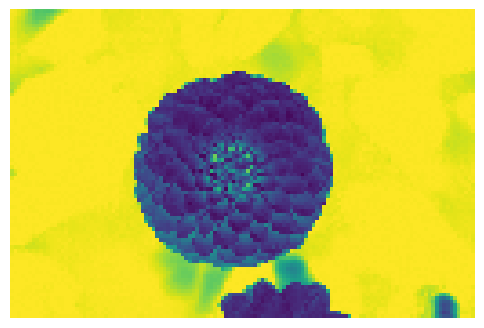

In [27]:
from sklearn.datasets import load_sample_images
from scipy.ndimage import zoom

dataset = load_sample_images()     
X = dataset.images[1]
X = zoom(X,.2) #decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = torch.tensor(X, dtype = torch.float64)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(flower)
off = ax.axis("off")

In [28]:
def corrupted_image(im, mean_patches = 5): 
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0

    X = im.clone()

    for _ in torch.arange(num_pixels_to_corrupt.item()): 
        
        try: 
            x = torch.randint(0, n_pixels[0], (2,))

            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))

            s = torch.randint(5, 10, (1,))
            
            patch = torch.zeros((s.item(), s.item()), dtype = torch.float64) + 0.5

            # place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1

            
        except: 
            pass

    return X, num_added

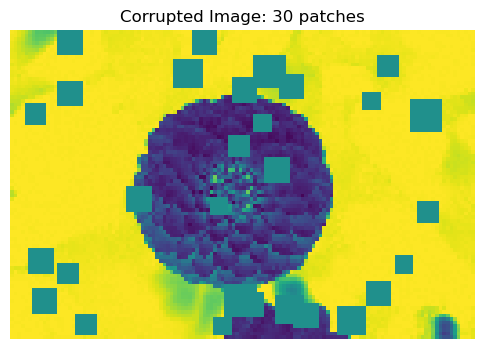

In [29]:
X, y = corrupted_image(flower, mean_patches = 50)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(X.numpy(), vmin = 0, vmax = 1)
ax.set(title = f"Corrupted Image: {y} patches")
off = plt.gca().axis("off")

In [30]:
n_samples = 200

X = torch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype = torch.float64)
y = torch.zeros(n_samples, dtype = torch.float64)
for i in range(n_samples): 
    X[i], y[i] = corrupted_image(flower, mean_patches = 100)

In [31]:
from sklearn.model_selection import train_test_split

X = X.reshape(n_samples, -1)
# X.reshape(n_samples, -1).size()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

### Performance of Model

Text(0, 0.5, 'Mean Squared Error (Testing)')

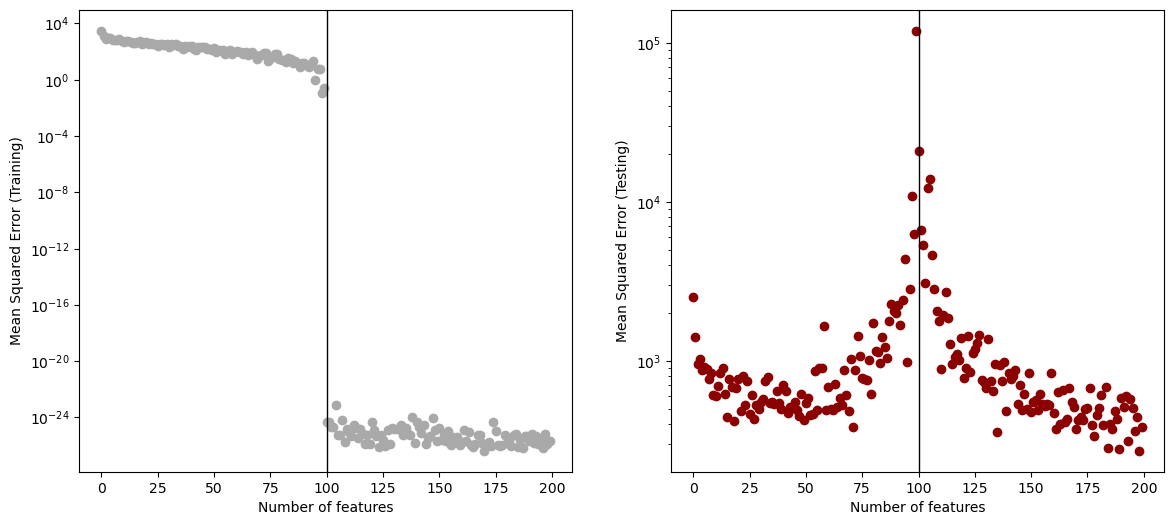

In [70]:
n_features = 200

train_loss_vec = []
test_loss_vec = []

n = X_train.size()[0] 
for i in range(n_features):
    phi = RandomFeatures(n_features = i, activation = square)
    phi.fit(X_train)
    
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)
    
    LR = MyLinearRegression()
    opt = OverParameterizedLinearRegressionOptimizer(LR)
    opt.fit(X_train_phi, y_train)
 
    train_loss = LR.loss(X_train_phi, y_train).item()
    test_loss = LR.loss(X_test_phi, y_test).item()

    train_loss_vec.append(train_loss)
    test_loss_vec.append(test_loss)
   
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  
ax[0].scatter(range(n_features), train_loss_vec, color='darkgrey')
ax[0].set_yscale('log')
ax[0].axvline(n, color='black', linewidth = 1)
ax[0].set_xlabel("Number of features")
ax[0].set_ylabel("Mean Squared Error (Training)")

ax[1].scatter(range(n_features), test_loss_vec, color='darkred')
ax[1].set_yscale('log')
ax[1].axvline(n, color='black', linewidth = 1)
ax[1].set_xlabel("Number of features")
ax[1].set_ylabel("Mean Squared Error (Testing)")


I achieved the best error rate at ...